# Version information

In [2]:
%matplotlib inline
from PySide2.QtWidgets import *
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
# Add cloned repo to system path to avoid having to pip-install as well
import sys
sys.path.append("C:/Users/nmb48/Documents/GitHub/pyleecan")  # Adjust path as needed
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: February 18, 2025
Pyleecan version:1.5.2
SciDataTool version:2.5.0


## Start the GUI

In [3]:
%run -m pyleecan

## Create new machine

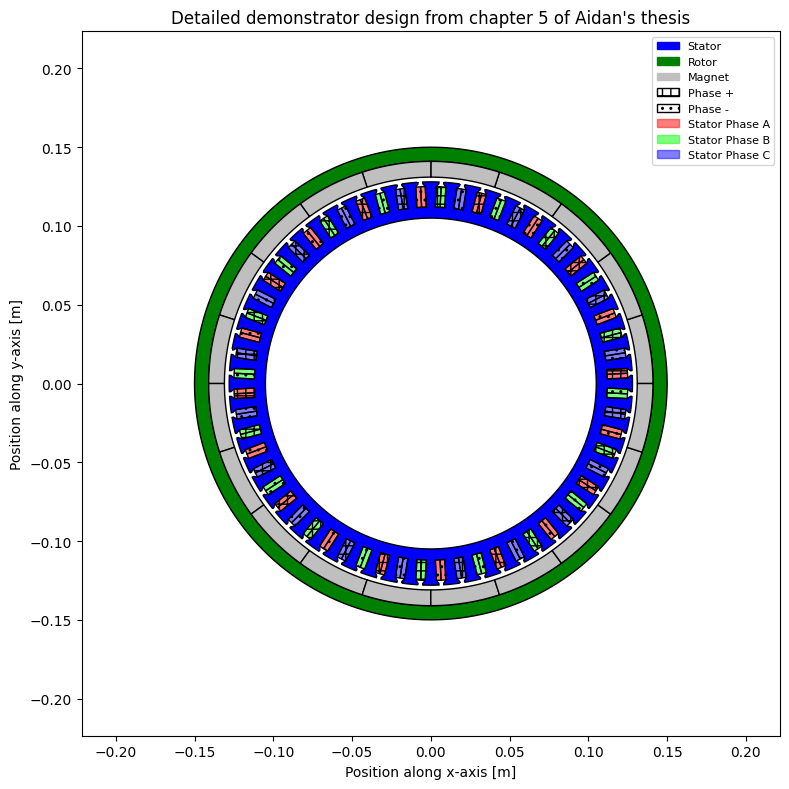

In [4]:
%matplotlib inline
from pyleecan.Functions.load import load
from os.path import abspath, dirname, basename, join, normpath, realpath

detailed_demonstrator_ch5 = load(join("detailed_demonstrator_ch5_scripted.json"))

fig, ax = detailed_demonstrator_ch5.plot(is_show_fig=False)  

## Simulation definition
### Inputs

The simulation is defined with a [**Simu1**](http://www.pyleecan.org/pyleecan.Classes.Simu1.html) object. This object corresponds to a simulation with 5 sequential physics (or modules):
- electrical  
- magnetic  
- force  
- structural  
- losses  

Each physics/modules can have several models to solve them. For now pyleecan includes:
- an Electrical model with one Equivalent circuit for PMSM machines and one for SCIM.
- a Magnetic model with FEMM for all machines
- a Force model (Maxwell Tensor)
- Magnetic and Structural models with GMSH/Elmer
- Losses models (FEMM, Bertotti, Steinmetz)

[**Simu1**](http://www.pyleecan.org/pyleecan.Classes.Simu1.html) object enforces a weak coupling between each physics: the input of each physic is the output of the previous one.

The Magnetic physics is defined with the object [**MagFEMM**](https://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) and the other physics are deactivated (set to None). 

We define the starting point of the simulation with an [**InputCurrent**](http://www.pyleecan.org/pyleecan.Classes.InputCurrent.html) object to enforce the electrical module output with:
- angular and the time discretization  
- rotor speed  
- stator currents  

In [5]:
from os.path import join
from numpy import ones, pi, array, linspace, cos, sqrt
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.MagFEMM import MagFEMM

# Create the Simulation
simu_femm = Simu1(name="FEMM_simulation", machine=detailed_demonstrator_ch5)   
# simu_femm.path_result = "path/to/folder" Path to the Result folder to use (will contain FEMM files)
p = simu_femm.machine.stator.winding.p
qs = simu_femm.machine.stator.winding.qs

# Defining Simulation Input
simu_femm.input = InputCurrent()

# Rotor speed [rpm]
N0 = 12500 
simu_femm.input.OP = OPdq(N0=N0)

# time discretization [s]
time = linspace(start=0, stop=60/N0, num=32*p, endpoint=False) # 32*p timesteps
simu_femm.input.time = time 

# Angular discretization along the airgap circonference for flux density calculation
simu_femm.input.angle = linspace(start = 0, stop = 2*pi, num=2048, endpoint=False) # 2048 steps 

# Stator currents as a function of time, each column correspond to one phase [A]
I0_rms = 103.96/sqrt(2) 
felec = p * N0 /60 # [Hz]
rot_dir = simu_femm.machine.stator.comp_mmf_dir()
Phi0 = 140*pi/180  # Maximum Torque Per Amp

Ia = (
    I0_rms
    * sqrt(2)
    * cos(2 * pi * felec * time + 0 * rot_dir * 2 * pi / qs + Phi0)
)
Ib = (
    I0_rms
    * sqrt(2)
    * cos(2 * pi * felec * time + 1 * rot_dir * 2 * pi / qs + Phi0)
)
Ic = (
    I0_rms
    * sqrt(2)
    * cos(2 * pi * felec * time + 2 * rot_dir * 2 * pi / qs + Phi0)
)
simu_femm.input.Is = array([Ia, Ib, Ic]).transpose()

In this example stator currents are enforced as a function of time for each phase. Sinusoidal current can also be defined with Id/Iq as explained in [this tutorial](https://www.pyleecan.org/04_tuto_Operating_point.html).

### MagFEMM configuration
For the configuration of the Magnetic module, we use the object [**MagFEMM**](https://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) that computes the airgap flux density by calling FEMM. The model parameters are set though the properties of the [**MagFEMM**](https://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) object. In this tutorial we will present the main ones, the complete list is available by looking at [**Magnetics**](http://www.pyleecan.org/pyleecan.Classes.Magnetics.html) and [**MagFEMM**](http://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) classes documentation.

*type_BH_stator* and *type_BH_rotor* enable to select how to model the B(H) curve of the laminations in FEMM. The material parameters and in particular the B(H) curve are setup directly [in the machine lamination material](https://www.pyleecan.org/01_tuto_Machine.html). 

In [6]:
from pyleecan.Classes.MagFEMM import MagFEMM

simu_femm.mag = MagFEMM(
    type_BH_stator=2, # 0 to use the material B(H) curve, 
                      # 1 to use linear B(H) curve according to mur_lin,
                      # 2 to enforce infinite permeability (mur_lin =100000)
    type_BH_rotor=2,  # 0 to use the material B(H) curve, 
                      # 1 to use linear B(H) curve according to mur_lin,
                      # 2 to enforce infinite permeability (mur_lin =100000)
    file_name = "detailed_demonstrator_ch5_femm", # Name of the file to save the FEMM model
    is_fast_draw=True,  # Speed-up drawing of the machine by using lamination periodicity
    is_sliding_band=True,  # True to use the symetry of the lamination to draw the machine faster
    is_calc_torque_energy=True, # True to calculate torque from integration of energy derivate over rotor elements
    T_mag=60,  # Permanent magnet temperature to adapt magnet remanent flux density [°C]
    is_remove_ventS=False,  # True to remove stator ventilation duct
    is_remove_ventR=False,  # True to remove rotor ventilation duct
)

# Only the magnetic module is defined
simu_femm.elec = None
simu_femm.force = None
simu_femm.struct = None 

In this example stator currents are enforced as a function of time for each phase. Sinusoidal current can also be defined with Id/Iq as explained in [this tutorial](https://www.pyleecan.org/04_tuto_Operating_point.html).

### MagFEMM configuration
For the configuration of the Magnetic module, we use the object [**MagFEMM**](https://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) that computes the airgap flux density by calling FEMM. The model parameters are set though the properties of the [**MagFEMM**](https://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) object. In this tutorial we will present the main ones, the complete list is available by looking at [**Magnetics**](http://www.pyleecan.org/pyleecan.Classes.Magnetics.html) and [**MagFEMM**](http://www.pyleecan.org/pyleecan.Classes.MagFEMM.html) classes documentation.

*type_BH_stator* and *type_BH_rotor* enable to select how to model the B(H) curve of the laminations in FEMM. The material parameters and in particular the B(H) curve are setup directly [in the machine lamination material](https://www.pyleecan.org/01_tuto_Machine.html). 

In [7]:
simu_femm.mag.is_periodicity_a=True
simu_femm.mag.is_periodicity_t=True
simu_femm.mag.nb_worker = 4  # Number of FEMM instances to run at the same time (1 by default)
simu_femm.mag.is_get_meshsolution = True # To get FEA mesh for latter post-procesing
simu_femm.mag.is_save_meshsolution_as_file = False # To save FEA results in a dat file
out_femm = simu_femm.run()

[12:15:14] Starting running simulation FEMM_simulation (machine=Detailed demonstrator design from chapter 5 of Aidan's thesis)
[12:15:14] Starting Magnetic module
[12:15:14] In Magnetic model, Na_tot=2048 is not divisible by the machine angular periodicity (10). Angular periodicity removed
[12:15:24] Computing Airgap Flux in FEMM
[12:16:06] End of simulation FEMM_simulation


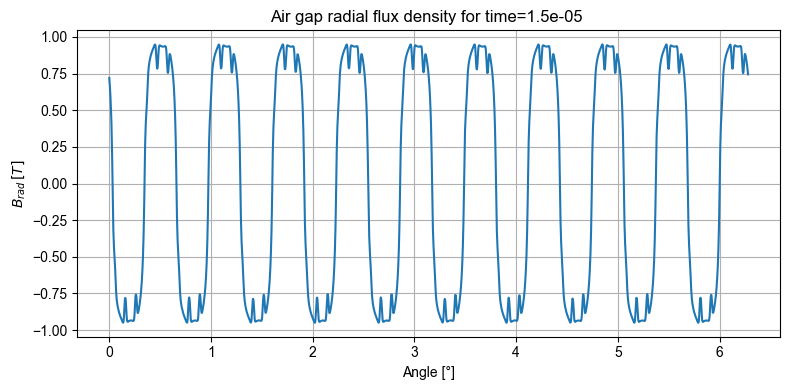

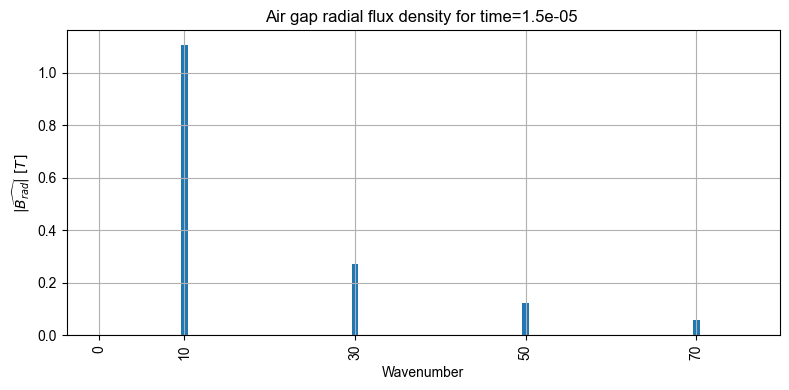

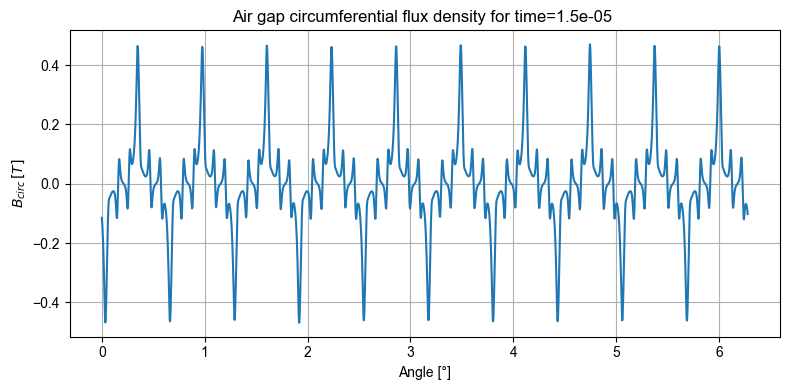

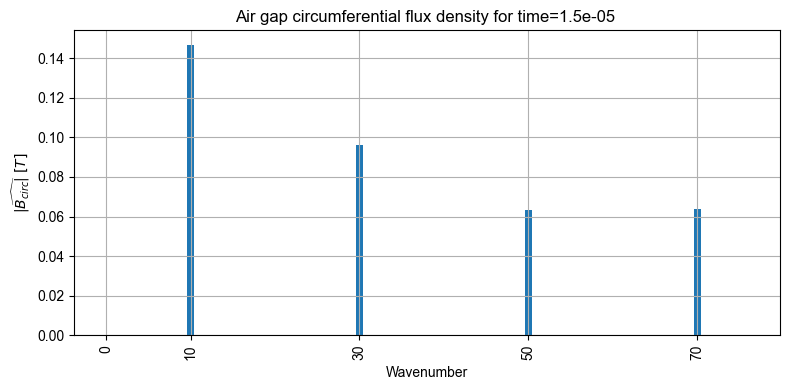

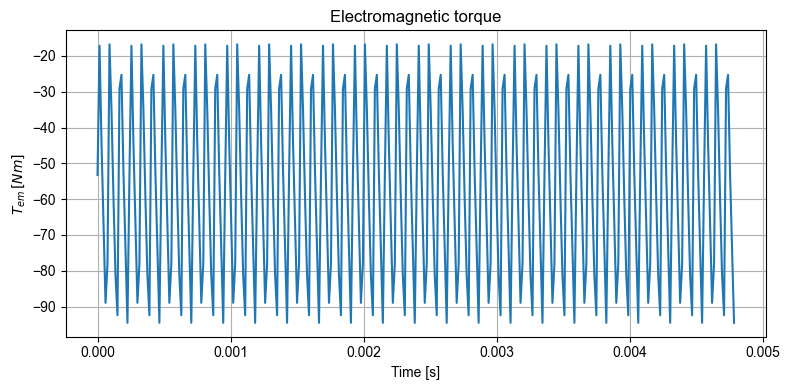

In [8]:
# Radial magnetic flux 
out_femm.mag.B.plot_2D_Data("angle","time[1]",component_list=["radial"], is_show_fig=False)
out_femm.mag.B.plot_2D_Data("wavenumber=[0,76]","time[1]",component_list=["radial"], is_show_fig=False)

# Tangential magnetic flux 
out_femm.mag.B.plot_2D_Data("angle","time[1]",component_list=["tangential"], is_show_fig=False)
out_femm.mag.B.plot_2D_Data("wavenumber=[0,76]","time[1]",component_list=["tangential"], is_show_fig=False)

# Torque
out_femm.mag.Tem.plot_2D_Data("time", is_show_fig=False)

In [1]:
# Magnetic flux density

# out_femm.mag.meshsolution.plot_contour(label="B", group_names="stator core", clim=[0,3])  # original command in '02_tuto_Simulation_FEMM.ipynb' tutorial - 'group_names="stator core"' argument no recognised

# Check allowed function arguments
# from inspect import signature
# sig = signature(out_femm.mag.meshsolution.plot_contour)
# print(sig)

out_femm.mag.meshsolution.plot_contour(label="B", clim=[0,3])

NameError: name 'out_femm' is not defined